# Loan Analysis & Prediction

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Exploratory Data Analysis

In [2]:
df_raw_data = pd.read_csv('./input/DR_Demo_Lending_Club_reduced.csv')
df_raw_data.head()

,Id,is_bad,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose_cat,zip_code,addr_state,...,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
0,1,0,10,MORTGAGE,50000.0,not verified,n,medical,766xx,TX,...,NaN,15.0,0.0,12087,12.1,44.0,f,0.0,1,PC4
1,2,0,1,RENT,39216.0,not verified,n,debt consolidation,660xx,KS,...,NaN,4.0,0.0,10114,64.0,5.0,f,0.0,2,PC1
2,3,0,4,RENT,65000.0,not verified,n,credit card,916xx,CA,...,NaN,4.0,0.0,81,0.6,8.0,f,0.0,3,PC4
3,4,0,10,MORTGAGE,57500.0,not verified,n,debt consolidation,124xx,NY,...,NaN,6.0,0.0,10030,37.1,23.0,f,0.0,2,PC2
4,5,0,10,MORTGAGE,50004.0,VERIFIED - income,n,debt consolidation,439xx,OH,...,NaN,8.0,0.0,10740,40.4,21.0,f,0.0,3,PC3


Data Describe

                Id        is_bad     annual_inc  debt_to_income  delinq_2yrs  \
count  10000.00000  10000.000000    9999.000000    10000.000000  9995.000000   
mean    5000.50000      0.129500   68203.011539       13.338704     0.148174   
std     2886.89568      0.335769   48590.252757        6.754212     0.506270   
min        1.00000      0.000000    2000.000000        0.000000     0.000000   
25%     2500.75000      0.000000   40000.000000        8.160000     0.000000   
50%     5000.50000      0.000000   58000.000000       13.410000     0.000000   
75%     7500.25000      0.000000   82000.000000       18.692500     0.000000   
max    10000.00000      1.000000  900000.000000       29.990000    11.000000   

       inq_last_6mths  mths_since_last_delinq  mths_since_last_record  \
count     9995.000000             3684.000000              840.000000   
mean         1.066933               35.890337               61.652381   
std          1.476052               22.361443

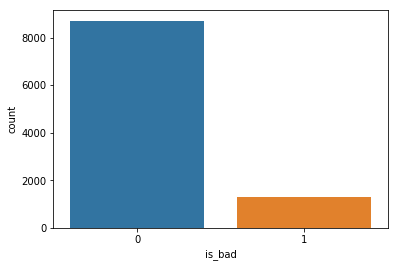

In [3]:
print('Data Describe\n')
print(df_raw_data.describe())
sns.countplot(x='is_bad', data=df_raw_data)

In [4]:
print('Data Describe - Annual Income and Number of times the loan applicant has missed a loan repayment during the past 2 years\n')
print(df_raw_data[['annual_inc','delinq_2yrs']].describe())



Data Describe - Annual Income and Number of times the loan applicant has missed a loan repayment during the past 2 years

          annual_inc  delinq_2yrs
count    9999.000000  9995.000000
mean    68203.011539     0.148174
std     48590.252757     0.506270
min      2000.000000     0.000000
25%     40000.000000     0.000000
50%     58000.000000     0.000000
75%     82000.000000     0.000000
max    900000.000000    11.000000


In [5]:
print('Data Corr\n')
print(df_raw_data.corr())

Data Corr

                                   Id    is_bad  annual_inc  debt_to_income  \
Id                           1.000000  0.010883    0.002736        0.014795   
is_bad                       0.010883  1.000000   -0.050975        0.029873   
annual_inc                   0.002736 -0.050975    1.000000       -0.130184   
debt_to_income               0.014795  0.029873   -0.130184        1.000000   
delinq_2yrs                 -0.000116  0.021842    0.038670       -0.034393   
inq_last_6mths               0.015789 -0.001146    0.056718        0.012819   
mths_since_last_delinq       0.010847  0.001358   -0.024578        0.057264   
mths_since_last_record      -0.001643  0.135735    0.006997        0.135642   
open_acc                     0.016304 -0.020356    0.233821        0.301003   
pub_rec                     -0.002248  0.032174   -0.010398       -0.005351   
revol_bal                    0.007223 -0.016202    0.359817        0.163794   
revol_util                   0.014310  0.

## Data Preprocessing

In [6]:
# `Id` is the database row ID of the loan applicant. This value is not very important. Therefore we need to delete this value.
df_data = df_raw_data.drop('Id', axis=1)



In [7]:
# Checks the missing values
print(df_raw_data.isnull().sum())
print('\n')
print(len(df_raw_data))

Id                                0
is_bad                            0
emp_length                        0
home_ownership                    0
annual_inc                        1
verification_status               0
pymnt_plan                        0
purpose_cat                       0
zip_code                          0
addr_state                        0
debt_to_income                    0
delinq_2yrs                       5
inq_last_6mths                    5
mths_since_last_delinq         6316
mths_since_last_record         9160
open_acc                          5
pub_rec                           5
revol_bal                         0
revol_util                       26
total_acc                         5
initial_list_status               0
collections_12_mths_ex_med       32
mths_since_last_major_derog       0
policy_code                       0
dtype: int64


10000


In [8]:
def find_quite_missing_value_columns(df):
    """
    Finds the column names which have quite missing values(NnN) in order to drop those columns.
    If the number of missing values are greater than the threshold(30% of the total rows)
    """
    missing_threshold = int(len(df) * 0.3)
    sum_isnull = df_raw_data.isnull().sum()
    drop_columns = []
    for col, null_count in sum_isnull.items():
        if null_count > missing_threshold:
            drop_columns.append(col)
    return drop_columns

In [9]:
# Needs to delete the fields such as `mths_since_last_delinq` and `mths_since_last_record` 
# because those fields values are quite missing.
# # drop_columns = find_quite_missing_value_columns(df_data)
# print("Dropped columns:", drop_columns)
# df_data = df_data.drop(drop_columns, axis=1)

In [10]:
df_data['mths_since_last_delinq'].fillna(0, inplace=True)
df_data['mths_since_last_record'].fillna(0, inplace=True)

In [11]:
# Drop rows that have not at least 5 non-NnN values.
df_data.dropna(thresh=5)

# Checks the missing values
print(df_data.isnull().sum())
print('\n')
print(len(df_data))

df_data

is_bad                          0
emp_length                      0
home_ownership                  0
annual_inc                      1
verification_status             0
pymnt_plan                      0
purpose_cat                     0
zip_code                        0
addr_state                      0
debt_to_income                  0
delinq_2yrs                     5
inq_last_6mths                  5
mths_since_last_delinq          0
mths_since_last_record          0
open_acc                        5
pub_rec                         5
revol_bal                       0
revol_util                     26
total_acc                       5
initial_list_status             0
collections_12_mths_ex_med     32
mths_since_last_major_derog     0
policy_code                     0
dtype: int64


10000


,is_bad,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose_cat,zip_code,addr_state,debt_to_income,...,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
0,0,10,MORTGAGE,50000.00,not verified,n,medical,766xx,TX,10.87,...,0.0,15.0,0.0,12087,12.1,44.0,f,0.0,1,PC4
1,0,1,RENT,39216.00,not verified,n,debt consolidation,660xx,KS,9.15,...,0.0,4.0,0.0,10114,64.0,5.0,f,0.0,2,PC1
2,0,4,RENT,65000.00,not verified,n,credit card,916xx,CA,11.24,...,0.0,4.0,0.0,81,0.6,8.0,f,0.0,3,PC4
3,0,10,MORTGAGE,57500.00,not verified,n,debt consolidation,124xx,NY,6.18,...,0.0,6.0,0.0,10030,37.1,23.0,f,0.0,2,PC2
4,0,10,MORTGAGE,50004.00,VERIFIED - income,n,debt consolidation,439xx,OH,19.03,...,0.0,8.0,0.0,10740,40.4,21.0,f,0.0,3,PC3
5,0,4,RENT,47028.00,VERIFIED - income,n,other,200xx,DC,7.83,...,0.0,6.0,0.0,1715,26.4,25.0,f,0.0,3,PC3
6,0,10,MORTGAGE,126000.00,not verified,n,credit card,103xx,NY,14.28,...,0.0,18.0,0.0,5466,11.1,29.0,f,0.0,3,PC1
7,0,6,MORTGAGE,42000.00,VERIFIED - income source,n,debt consolidation,891xx,NV,10.29,...,0.0,9.0,0.0,10354,95.9,10.0,f,0.0,3,PC3
8,0,2,MORTGAGE,50000.00,VERIFIED - income,n,debt consolidation,612xx,IL,15.36,...,0.0,11.0,0.0,19662,59.2,27.0,f,0.0,1,PC5
9,0,1,RENT,40000.00,not verified,n,car,926xx,CA,6.48,...,0.0,11.0,0.0,19998,18.3,23.0,f,0.0,1,PC5


In [12]:
# Convert the categorical data
print('addr_state:')
print(df_data.addr_state.unique())

print('\nzip_code:')
#print(df_data.zip_code.unique())

print('\nhome_ownership:')
print(df_data.home_ownership.unique())

print('\ninitial_list_status:')
print(df_data.initial_list_status.unique())
# dummies = pd.get_dummies(df_data['initial_list_status']).rename(columns=lambda x: 'is_' + str(x))
# df_data = pd.concat([df_data, dummies], axis=1)
# df_data = df_data.drop(['initial_list_status'],  axis=1)

print('\npymnt_plan:')
print(df_data.pymnt_plan.unique())

print('\npolicy_code:')
print(df_data.policy_code.unique())

print('\nverification_status:')
print(df_data.verification_status.unique())

print('\npurpose_cat:')
print(df_data.purpose_cat.unique())


categorical_mapping = {
    "pymnt_plan": {"n": 0, "y": 1},
    "initial_list_status": {"f": 0, "m": 1},
    "home_ownership": {"NONE": 1, "OTHER": 2, "MORTGAGE": 3, "RENT": 4, "OWN":  5},
    "policy_code": {"PC1": 1, "PC2": 2, "PC3": 3, "PC4": 4, "PC5":  5},
    "verification_status": {"not verified": 0, "VERIFIED - income": 1, "VERIFIED - income source": 1},
}

addr_state_mapping = {
    label:idx for idx,label in
    enumerate(np.unique(df_data['addr_state']))
}

zip_code_mapping = {
    label:idx for idx,label in
    enumerate(np.unique(df_data['zip_code']))
}

purpose_cat_mapping = {
    label:idx for idx,label in
    enumerate(np.unique(df_data['purpose_cat']))
}

df_data.replace(categorical_mapping, inplace=True)
df_data.replace(addr_state_mapping, inplace=True)
df_data.replace(zip_code_mapping, inplace=True)
df_data.replace(purpose_cat_mapping, inplace=True)

df_data.head()



addr_state:
['TX' 'KS' 'CA' 'NY' 'OH' 'DC' 'NV' 'IL' 'WA' 'DE' 'FL' 'NJ' 'OK' 'VA'
 'NH' 'MA' 'NC' 'OR' 'GA' 'CO' 'MD' 'CT' 'MO' 'WI' 'AZ' 'SC' 'MN' 'MI'
 'PA' 'AK' 'AR' 'LA' 'HI' 'WV' 'KY' 'RI' 'AL' 'SD' 'NM' 'ID' 'UT' 'MT'
 'WY' 'VT' 'TN' 'IA' 'MS' 'NE' 'IN' 'ME']

zip_code:

home_ownership:
['MORTGAGE' 'RENT' 'OWN' 'OTHER' 'NONE']

initial_list_status:
['f' 'm']

pymnt_plan:
['n' 'y']

policy_code:
['PC4' 'PC1' 'PC2' 'PC3' 'PC5']

verification_status:
['not verified' 'VERIFIED - income' 'VERIFIED - income source']

purpose_cat:
['medical' 'debt consolidation' 'credit card' 'other' 'car' 'wedding'
 'other small business' 'house' 'small business' 'educational'
 'major purchase' 'home improvement' 'vacation'
 'debt consolidation small business' 'moving' 'credit card small business'
 'wedding small business' 'small business small business'
 'home improvement small business' 'major purchase small business'
 'educational small business' 'house small business' 'renewable energy'
 'moving s

,is_bad,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose_cat,zip_code,addr_state,debt_to_income,...,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
0,0,10,3,50000.0,0,0,14,555,42,10.87,...,0.0,15.0,0.0,12087,12.1,44.0,0,0.0,1,4
1,0,1,4,39216.0,0,0,4,487,16,9.15,...,0.0,4.0,0.0,10114,64.0,5.0,0,0.0,2,1
2,0,4,4,65000.0,0,0,2,649,4,11.24,...,0.0,4.0,0.0,81,0.6,8.0,0,0.0,3,4
3,0,10,3,57500.0,0,0,4,88,33,6.18,...,0.0,6.0,0.0,10030,37.1,23.0,0,0.0,2,2
4,0,10,3,50004.0,1,0,4,348,34,19.03,...,0.0,8.0,0.0,10740,40.4,21.0,0,0.0,3,3


In [13]:
# Imputing the sparse missing values such as `annual_inc`.
from sklearn.impute import SimpleImputer

# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# df_data.head()
# imputer.fit(df_data)
# df_data_imputed = imputer.transform(df_data.values)

df_data = df_data.fillna(df_data.mean())
df_data['emp_length'] = df_data['emp_length'].apply(lambda x: 0 if x == 'na' else x)

In [14]:
# Checks the missing values
print(df_data.isnull().sum())
print('\n')
print(len(df_data))


is_bad                         0
emp_length                     0
home_ownership                 0
annual_inc                     0
verification_status            0
pymnt_plan                     0
purpose_cat                    0
zip_code                       0
addr_state                     0
debt_to_income                 0
delinq_2yrs                    0
inq_last_6mths                 0
mths_since_last_delinq         0
mths_since_last_record         0
open_acc                       0
pub_rec                        0
revol_bal                      0
revol_util                     0
total_acc                      0
initial_list_status            0
collections_12_mths_ex_med     0
mths_since_last_major_derog    0
policy_code                    0
dtype: int64


10000


## Training a logistic regression model

In [15]:
from prediction_model import PredictionModel

model = PredictionModel(solver='lbfgs', penalty='l2', max_iter=1000, debug=True)

In [16]:
X = df_data.drop('is_bad', axis=1)
X = X.drop('emp_length', axis=1)
y = df_data['is_bad'].values
model.fit(X, y)

LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
score = model.score(X, y)
print(score)

AttributeError: 'PredictionModel' object has no attribute 'score'